In [4]:
# Paths
trt_file = "weights/fcn-resnet50-12-fp16.engine"
input_file = "demo/airforce_one.jpg"
output_file = "demo/test.jpg"

In [5]:

import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

import matplotlib.pyplot as plt
from PIL import Image

In [6]:
TRT_LOGGER = trt.Logger()
ctx = pycuda.autoinit.context
ctx.push()

In [7]:
# Pre and Post Processing
def preprocess(image):
    # Mean normalization
    mean = np.array([0.485, 0.456, 0.406]).astype('float32')
    stddev = np.array([0.229, 0.224, 0.225]).astype('float32')
    data = (np.asarray(image).astype('float32') / float(255.0) - mean) / stddev
    # Switch from HWC to to CHW order
    return np.moveaxis(data, 2, 0)

def postprocess(data):
    num_classes = 21
    # create a color palette, selecting a color for each class
    palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = np.array([palette*i%255 for i in range(num_classes)]).astype("uint8")
    # plot the segmentation predictions for 21 classes in different colors
    img = Image.fromarray(data.astype('uint8'), mode='P')
    img.putpalette(colors)
    return img

In [8]:
# Load Engine
def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

In [9]:
# Inference Code
def infer(engine, input_file, output_file):
    print("Reading input image from file {}".format(input_file))
    with Image.open(input_file) as img:
        input_image = preprocess(img)
        image_width = img.width
        image_height = img.height
    print("Input Image Shpae: ", input_image.shape)

    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        context.set_binding_shape(engine.get_binding_index("input"), 
                                  (1, 3, image_height, image_width))
        # context.set_binding_shape(engine.get_binding_index("output"), 
        #                           (1, 21, image_height, image_width))
        # Allocate host and device buffers
        bindings = []
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            if engine.binding_is_input(binding):
                input_buffer = np.ascontiguousarray(input_image)
                input_memory = cuda.mem_alloc(input_image.nbytes)
                bindings.append(int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                bindings.append(int(output_memory))

        stream = cuda.Stream()
        # Transfer input data to the GPU.
        print("Transferred input data")
        cuda.memcpy_htod_async(input_memory, input_buffer, stream)
        # Run inference
        print("Running Inference")
        context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
        # Transfer prediction output from the GPU.
        cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
        # Synchronize the stream
        stream.synchronize()

    with postprocess(np.reshape(output_buffer, (image_height, image_width))) as img:
        print("Writing output image to file {}".format(output_file))
        img.convert('RGB').save(output_file, "JPG")

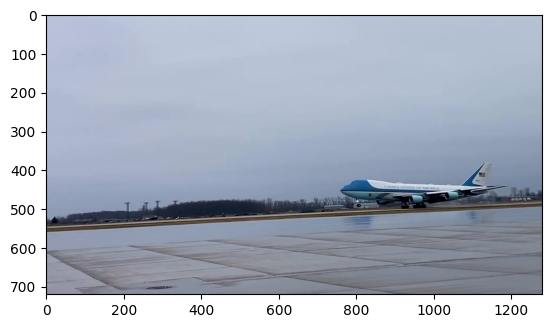

In [10]:
# Plot Input Image
plt.imshow(Image.open(input_file))


In [11]:
# Run Inference
print("Running TensorRT inference for FCN-ResNet101")
with load_engine(trt_file) as engine:
    infer(engine, input_file, output_file)

Running TensorRT inference for FCN-ResNet101
Reading engine from file weights/fcn-resnet50-12-fp16.engine
Reading input image from file demo/airforce_one.jpg
Input Image Shpae:  (3, 720, 1280)
[03/15/2024-15:05:54] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
Transferred input data
Running Inference


/tmp/ipykernel_794112/2029126771.py:12: DeprecationWarning: Use get_tensor_name instead.
  context.set_binding_shape(engine.get_binding_index("input"),
/tmp/ipykernel_794112/2029126771.py:12: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(engine.get_binding_index("input"),
/tmp/ipykernel_794112/2029126771.py:19: DeprecationWarning: Use get_tensor_name instead.
  binding_idx = engine.get_binding_index(binding)
/tmp/ipykernel_794112/2029126771.py:20: DeprecationWarning: Use get_tensor_shape instead.
  size = trt.volume(context.get_binding_shape(binding_idx))
/tmp/ipykernel_794112/2029126771.py:21: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(engine.get_binding_dtype(binding))
/tmp/ipykernel_794112/2029126771.py:22: DeprecationWarning: Use get_tensor_mode instead.
  if engine.binding_is_input(binding):


LogicError: cuStreamSynchronize failed: an illegal memory access was encountered

In [13]:
# Plot output
plt.imshow(Image.open(output_file))

FileNotFoundError: [Errno 2] No such file or directory: 'demo/test.jpg'

In [ ]:
ctx.pop()